# GoEmotions - Analysis Pipeline

**Task**: Multi-label Emotion Classification  
**Objective**: Deep dive into model behavior and errors  

---

## Pipeline Overview

1. Environment Setup
2. Load Results
3. Error Pattern Analysis
4. Confidence Analysis
5. Multi-label Co-occurrence Errors
6. Cross-Model Disagreement
7. Hard Sample Analysis
8. Recommendations

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets
!pip install -q matplotlib seaborn pandas numpy wordcloud

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import torch
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [3]:
class AnalysisConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    EVAL_DIR = './evaluation'
    ANALYSIS_DIR = './analysis'
    
    MODELS = {
        'bert-base': 'go_emotions_bert-base_best',
        'distilbert': 'go_emotions_distilbert_best',
        'tinybert': 'go_emotions_tinybert_best'
    }

config = AnalysisConfig()
os.makedirs(config.ANALYSIS_DIR, exist_ok=True)

config_path = os.path.join(config.DATA_DIR, 'go_emotions_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

LABEL_NAMES = data_config['label_names']
NUM_LABELS = data_config['num_labels']

print(f"📋 Configuration loaded!")
print(f"   Number of labels: {NUM_LABELS}")

📋 Configuration loaded!
   Number of labels: 28


## 2. Load Results

In [4]:
report_path = os.path.join(config.EVAL_DIR, 'evaluation_report.json')
with open(report_path, 'r') as f:
    eval_report = json.load(f)

print("📊 Evaluation report loaded!")

optimal_thresholds = {
    name: data['optimal_threshold']
    for name, data in eval_report['models'].items()
}

📊 Evaluation report loaded!


In [5]:
print("📥 Loading test dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'go_emotions_tokenized')
dataset = load_from_disk(dataset_path)
test_dataset = dataset['test']

test_texts = test_dataset['text'] if 'text' in test_dataset.features else None

print(f"✅ Test dataset: {len(test_dataset):,} samples")

📥 Loading test dataset...
✅ Test dataset: 5,427 samples


In [6]:
def load_model(model_name):
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    return model, tokenizer

@torch.no_grad()
def get_predictions_batch(model, dataset, batch_size=32):
    """Get predictions and probabilities."""
    from torch.utils.data import DataLoader
    
    model.eval()
    all_logits = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        all_logits.extend(outputs.logits.cpu().numpy())
        all_labels.extend(batch['labels'].numpy())
    
    logits = np.array(all_logits)
    labels = np.array(all_labels)
    probs = 1 / (1 + np.exp(-logits))
    
    return {'logits': logits, 'probabilities': probs, 'labels': labels}

print("📦 Loading models and predictions...")
results = {}

for model_name in config.MODELS.keys():
    print(f"   Loading {model_name}...")
    model, _ = load_model(model_name)
    results[model_name] = get_predictions_batch(model, test_dataset)
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n✅ All predictions obtained!")

📦 Loading models and predictions...
   Loading bert-base...
   Loading distilbert...
   Loading tinybert...

✅ All predictions obtained!


## 3. Error Pattern Analysis

In [7]:
def analyze_error_patterns(y_true, y_prob, label_names, threshold=0.5):
    """Analyze error patterns for multi-label classification."""
    y_pred = (y_prob > threshold).astype(int)
    
    false_positives = (y_pred == 1) & (y_true == 0)
    false_negatives = (y_true == 1) & (y_pred == 0)
    
    fp_per_label = false_positives.sum(axis=0)
    fn_per_label = false_negatives.sum(axis=0)
    
    error_df = pd.DataFrame({
        'label': label_names,
        'false_positives': fp_per_label,
        'false_negatives': fn_per_label,
        'total_errors': fp_per_label + fn_per_label,
        'support': y_true.sum(axis=0),
        'fp_rate': fp_per_label / (y_true == 0).sum(axis=0),
        'fn_rate': fn_per_label / np.maximum(y_true.sum(axis=0), 1)
    })
    
    return error_df, false_positives, false_negatives

best_model = 'bert-base'
y_true = results[best_model]['labels']
y_prob = results[best_model]['probabilities']
threshold = optimal_thresholds[best_model]

error_df, fp_matrix, fn_matrix = analyze_error_patterns(y_true, y_prob, LABEL_NAMES, threshold)
error_df = error_df.sort_values('total_errors', ascending=False)

print(f"📊 Error Analysis ({best_model}, threshold={threshold:.2f}):")
print("="*80)
print(error_df.head(15).round(4).to_string(index=False))

📊 Error Analysis (bert-base, threshold=0.75):
         label  false_positives  false_negatives  total_errors  support  fp_rate  fn_rate
       neutral              272              939          1211     1787   0.0747   0.5255
     annoyance              351              178           529      320   0.0687   0.5562
      approval              259              188           447      351   0.0510   0.5356
   disapproval              215              135           350      267   0.0417   0.5056
    admiration              248              100           348      504   0.0504   0.1984
     curiosity              266               63           329      284   0.0517   0.2218
         anger              156               80           236      198   0.0298   0.4040
     confusion              165               64           229      153   0.0313   0.4183
disappointment               89              104           193      151   0.0169   0.6887
      optimism               98               76      

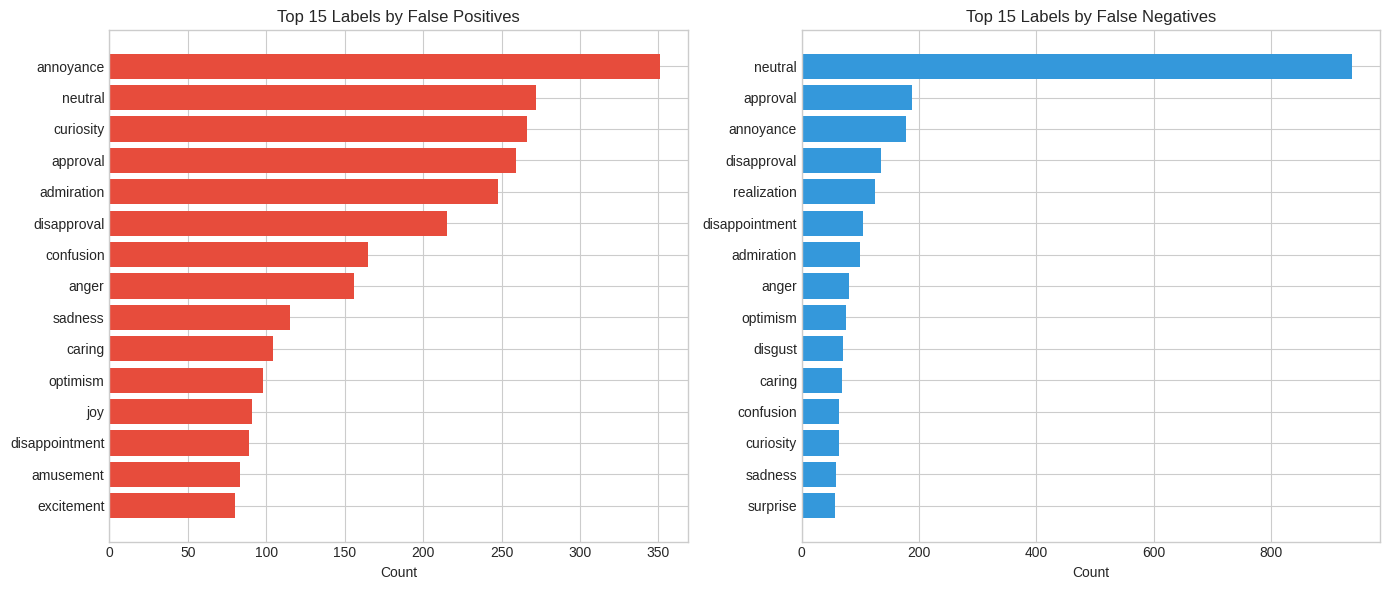

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_fp = error_df.nlargest(15, 'false_positives')
axes[0].barh(top_fp['label'], top_fp['false_positives'], color='#e74c3c')
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Labels by False Positives')
axes[0].invert_yaxis()

top_fn = error_df.nlargest(15, 'false_negatives')
axes[1].barh(top_fn['label'], top_fn['false_negatives'], color='#3498db')
axes[1].set_xlabel('Count')
axes[1].set_title('Top 15 Labels by False Negatives')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'error_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Confidence Analysis

In [9]:
def analyze_confidence(y_true, y_prob, threshold=0.5):
    """Analyze confidence distribution for correct/incorrect predictions."""
    y_pred = (y_prob > threshold).astype(int)
    
    correct_mask = (y_pred == y_true)
    incorrect_mask = (y_pred != y_true)
    
    correct_probs = y_prob[correct_mask]
    incorrect_probs = y_prob[incorrect_mask]
    
    max_conf_per_sample = y_prob.max(axis=1)
    
    exact_match = (y_pred == y_true).all(axis=1)
    
    return {
        'correct_probs': correct_probs,
        'incorrect_probs': incorrect_probs,
        'max_conf_per_sample': max_conf_per_sample,
        'exact_match': exact_match
    }

conf_analysis = analyze_confidence(y_true, y_prob, threshold)

print("📊 Confidence Statistics:")
print(f"   Correct predictions: mean conf = {conf_analysis['correct_probs'].mean():.4f}")
print(f"   Incorrect predictions: mean conf = {conf_analysis['incorrect_probs'].mean():.4f}")

📊 Confidence Statistics:
   Correct predictions: mean conf = 0.0958
   Incorrect predictions: mean conf = 0.6475


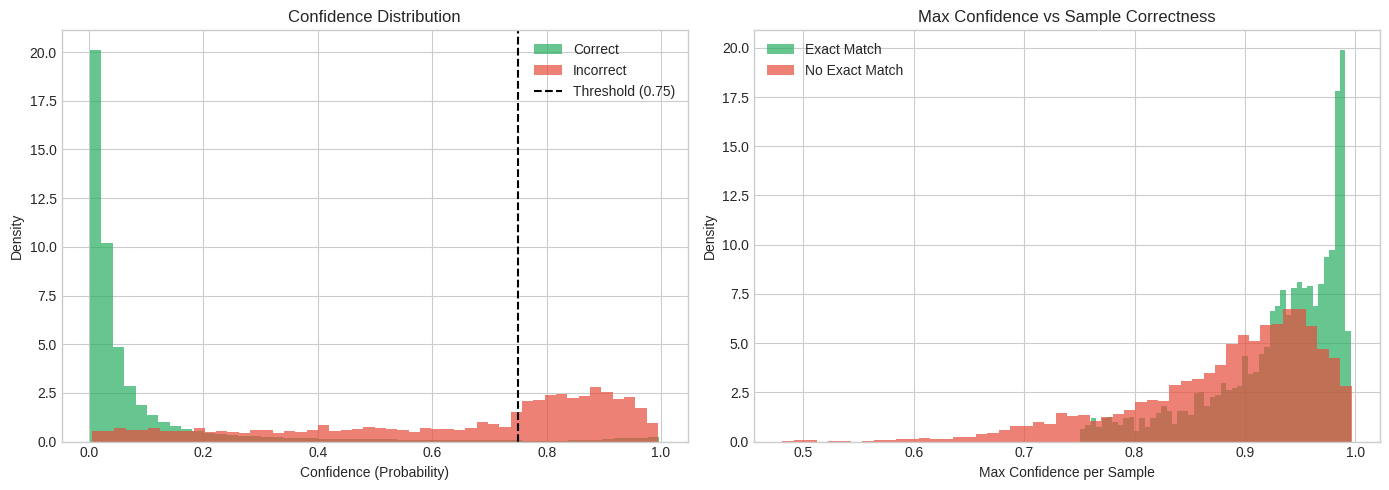

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(conf_analysis['correct_probs'], bins=50, alpha=0.7, label='Correct', color='#27ae60', density=True)
axes[0].hist(conf_analysis['incorrect_probs'], bins=50, alpha=0.7, label='Incorrect', color='#e74c3c', density=True)
axes[0].axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.2f})')
axes[0].set_xlabel('Confidence (Probability)')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence Distribution')
axes[0].legend()

max_conf_correct = conf_analysis['max_conf_per_sample'][conf_analysis['exact_match']]
max_conf_incorrect = conf_analysis['max_conf_per_sample'][~conf_analysis['exact_match']]

axes[1].hist(max_conf_correct, bins=50, alpha=0.7, label='Exact Match', color='#27ae60', density=True)
axes[1].hist(max_conf_incorrect, bins=50, alpha=0.7, label='No Exact Match', color='#e74c3c', density=True)
axes[1].set_xlabel('Max Confidence per Sample')
axes[1].set_ylabel('Density')
axes[1].set_title('Max Confidence vs Sample Correctness')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'confidence_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Multi-label Co-occurrence Errors

In [11]:
def analyze_cooccurrence_errors(y_true, y_pred, label_names):
    """Analyze which label pairs frequently have errors together."""
    error_mask = (y_pred != y_true).any(axis=1)
    error_indices = np.where(error_mask)[0]
    
    fp_counts = Counter()
    fn_counts = Counter()
    
    for idx in error_indices:
        true_labels = set(np.where(y_true[idx] == 1)[0])
        pred_labels = set(np.where(y_pred[idx] == 1)[0])
        
        fp_labels = pred_labels - true_labels
        for l in fp_labels:
            fp_counts[label_names[l]] += 1
        
        fn_labels = true_labels - pred_labels
        for l in fn_labels:
            fn_counts[label_names[l]] += 1
    
    return fp_counts, fn_counts, len(error_indices)

y_pred = (y_prob > threshold).astype(int)
fp_counts, fn_counts, num_errors = analyze_cooccurrence_errors(y_true, y_pred, LABEL_NAMES)

print(f"📊 Samples with errors: {num_errors:,} / {len(y_true):,} ({num_errors/len(y_true)*100:.1f}%)")
print(f"\n🔴 Most common False Positive labels:")
for label, count in fp_counts.most_common(10):
    print(f"   {label}: {count}")

print(f"\n🔵 Most common False Negative labels:")
for label, count in fn_counts.most_common(10):
    print(f"   {label}: {count}")

📊 Samples with errors: 3,184 / 5,427 (58.7%)

🔴 Most common False Positive labels:
   annoyance: 351
   neutral: 272
   curiosity: 266
   approval: 259
   admiration: 248
   disapproval: 215
   confusion: 165
   anger: 156
   sadness: 115
   caring: 104

🔵 Most common False Negative labels:
   neutral: 939
   approval: 188
   annoyance: 178
   disapproval: 135
   realization: 124
   disappointment: 104
   admiration: 100
   anger: 80
   optimism: 76
   disgust: 70


In [12]:
def compute_label_confusion_matrix(y_true, y_pred, label_names):
    """Compute which predicted labels are confused with which true labels."""
    n_labels = len(label_names)
    confusion = np.zeros((n_labels, n_labels))
    
    for i in range(len(y_true)):
        true_labels = set(np.where(y_true[i] == 1)[0])
        pred_labels = set(np.where(y_pred[i] == 1)[0])
        
        fp_labels = pred_labels - true_labels
        
        for fp in fp_labels:
            for true_l in true_labels:
                confusion[true_l, fp] += 1
    
    return confusion

confusion_matrix = compute_label_confusion_matrix(y_true, y_pred, LABEL_NAMES)

confusions = []
for i in range(len(LABEL_NAMES)):
    for j in range(len(LABEL_NAMES)):
        if i != j and confusion_matrix[i, j] > 0:
            confusions.append({
                'true_label': LABEL_NAMES[i],
                'pred_label': LABEL_NAMES[j],
                'count': int(confusion_matrix[i, j])
            })

confusion_df = pd.DataFrame(confusions).sort_values('count', ascending=False)
print("\n🔄 Top Label Confusions (True → Predicted):")
print(confusion_df.head(15).to_string(index=False))


🔄 Top Label Confusions (True → Predicted):
 true_label  pred_label  count
    neutral   curiosity    142
    neutral    approval    140
    neutral   annoyance    113
    neutral disapproval    112
      anger   annoyance    110
    neutral   confusion     79
    neutral  admiration     74
  annoyance       anger     60
  curiosity   confusion     55
   approval     neutral     54
    neutral       anger     53
  confusion   curiosity     48
disapproval     neutral     46
    neutral      caring     43
    disgust   annoyance     41


## 6. Cross-Model Disagreement

In [13]:
def analyze_model_agreement(results, optimal_thresholds):
    """Analyze where models agree and disagree."""
    model_names = list(results.keys())
    
    predictions = {}
    for name in model_names:
        probs = results[name]['probabilities']
        thresh = optimal_thresholds[name]
        predictions[name] = (probs > thresh).astype(int)
    
    true_labels = results[model_names[0]]['labels']
    n_samples = len(true_labels)
    
    all_agree = np.ones(n_samples, dtype=bool)
    all_correct = np.ones(n_samples, dtype=bool)
    
    for name in model_names:
        pred = predictions[name]
        correct = (pred == true_labels).all(axis=1)
        all_correct &= correct
    
    for i, name1 in enumerate(model_names):
        for name2 in model_names[i+1:]:
            agreement = (predictions[name1] == predictions[name2]).all(axis=1)
            all_agree &= agreement
    
    return {
        'all_agree': all_agree,
        'all_correct': all_correct,
        'predictions': predictions
    }

agreement = analyze_model_agreement(results, optimal_thresholds)

n_total = len(agreement['all_agree'])
n_all_agree = agreement['all_agree'].sum()
n_all_correct = agreement['all_correct'].sum()

print("📊 Model Agreement Analysis:")
print(f"   Total samples: {n_total:,}")
print(f"   All models agree: {n_all_agree:,} ({n_all_agree/n_total*100:.1f}%)")
print(f"   All models correct: {n_all_correct:,} ({n_all_correct/n_total*100:.1f}%)")
print(f"   Disagreement: {n_total - n_all_agree:,} ({(n_total-n_all_agree)/n_total*100:.1f}%)")

📊 Model Agreement Analysis:
   Total samples: 5,427
   All models agree: 1,326 (24.4%)
   All models correct: 796 (14.7%)
   Disagreement: 4,101 (75.6%)


In [14]:
disagree_indices = np.where(~agreement['all_agree'])[0]

unique_correct = {name: 0 for name in results.keys()}

true_labels = results['bert-base']['labels']

for idx in disagree_indices:
    correct_models = []
    for name, preds in agreement['predictions'].items():
        if (preds[idx] == true_labels[idx]).all():
            correct_models.append(name)
    
    if len(correct_models) == 1:
        unique_correct[correct_models[0]] += 1

print("\n🏆 Uniquely Correct (one model right, others wrong):")
for name, count in unique_correct.items():
    print(f"   {name}: {count} samples")


🏆 Uniquely Correct (one model right, others wrong):
   bert-base: 318 samples
   distilbert: 174 samples
   tinybert: 303 samples


## 7. Hard Sample Analysis

In [15]:
def find_hard_samples(y_true, y_prob, threshold=0.5, n_samples=20):
    """Find samples that are hardest to classify correctly."""
    y_pred = (y_prob > threshold).astype(int)
    
    hamming_dist = (y_pred != y_true).sum(axis=1)
    
    hard_indices = np.argsort(hamming_dist)[::-1][:n_samples]
    
    return hard_indices, hamming_dist

hard_indices, hamming_dist = find_hard_samples(y_true, y_prob, threshold)

print("🔍 Hard Samples (most label mismatches):")
print("="*80)

for i, idx in enumerate(hard_indices[:10]):
    y_pred = (y_prob[idx] > threshold).astype(int)
    
    true_emotions = [LABEL_NAMES[j] for j in np.where(y_true[idx] == 1)[0]]
    pred_emotions = [LABEL_NAMES[j] for j in np.where(y_pred == 1)[0]]
    
    print(f"\n[Sample {idx}] Hamming Distance: {hamming_dist[idx]}")
    print(f"   True: {true_emotions}")
    print(f"   Pred: {pred_emotions}")
    if test_texts is not None:
        text = test_texts[idx][:150] + '...' if len(test_texts[idx]) > 150 else test_texts[idx]
        print(f"   Text: \"{text}\"")

🔍 Hard Samples (most label mismatches):

[Sample 3345] Hamming Distance: 5
   True: ['embarrassment', 'sadness']
   Pred: ['annoyance', 'disgust', 'fear']

[Sample 1187] Hamming Distance: 5
   True: ['anger', 'annoyance', 'disappointment']
   Pred: ['confusion', 'curiosity']

[Sample 4260] Hamming Distance: 5
   True: ['amusement', 'disgust', 'realization']
   Pred: ['anger', 'annoyance']

[Sample 2211] Hamming Distance: 4
   True: ['optimism']
   Pred: ['admiration', 'excitement', 'joy']

[Sample 4086] Hamming Distance: 4
   True: ['approval', 'excitement', 'surprise']
   Pred: ['admiration', 'excitement', 'gratitude']

[Sample 3197] Hamming Distance: 4
   True: ['disapproval', 'optimism']
   Pred: ['admiration', 'approval']

[Sample 3246] Hamming Distance: 4
   True: ['admiration', 'excitement']
   Pred: ['amusement', 'joy']

[Sample 2642] Hamming Distance: 4
   True: ['admiration', 'disapproval']
   Pred: ['disappointment', 'sadness']

[Sample 3707] Hamming Distance: 4
   True: ['gr

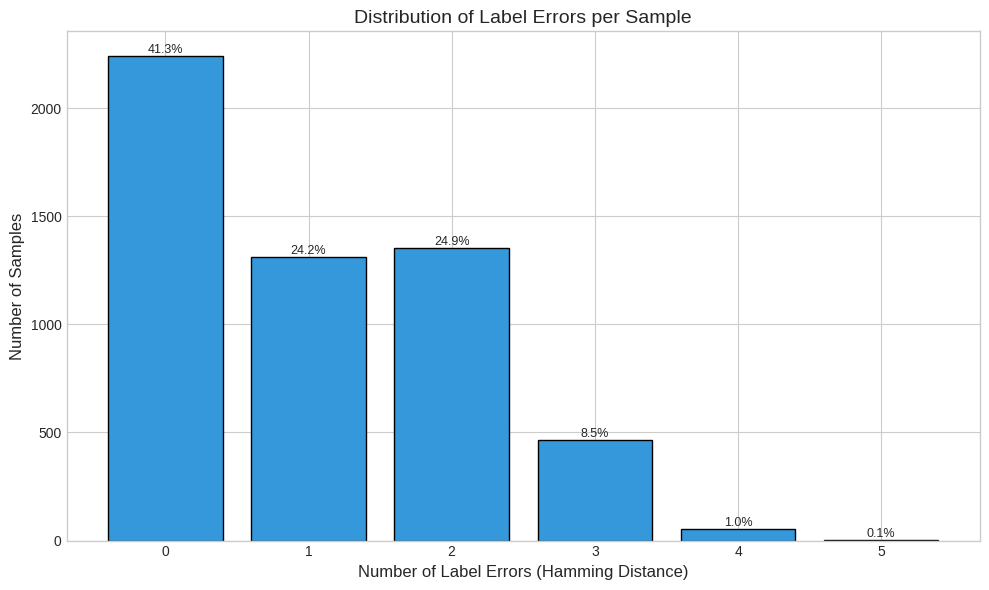

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

unique, counts = np.unique(hamming_dist, return_counts=True)

ax.bar(unique, counts, color='#3498db', edgecolor='black')
ax.set_xlabel('Number of Label Errors (Hamming Distance)', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Distribution of Label Errors per Sample', fontsize=14)

total = counts.sum()
for u, c in zip(unique[:10], counts[:10]):
    ax.annotate(f'{c/total*100:.1f}%', (u, c), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'error_distribution_per_sample.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Word Cloud Analysis

In [17]:
if test_texts is not None:
    y_pred = (y_prob > threshold).astype(int)
    exact_match = (y_pred == y_true).all(axis=1)
    
    correct_texts = ' '.join([test_texts[i] for i in np.where(exact_match)[0]])
    incorrect_texts = ' '.join([test_texts[i] for i in np.where(~exact_match)[0]])
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    if correct_texts:
        wc_correct = WordCloud(width=800, height=400, background_color='white',
                              colormap='Greens', max_words=100).generate(correct_texts)
        axes[0].imshow(wc_correct, interpolation='bilinear')
        axes[0].axis('off')
        axes[0].set_title('Correctly Classified Samples', fontsize=14)
    
    if incorrect_texts:
        wc_incorrect = WordCloud(width=800, height=400, background_color='white',
                                colormap='Reds', max_words=100).generate(incorrect_texts)
        axes[1].imshow(wc_incorrect, interpolation='bilinear')
        axes[1].axis('off')
        axes[1].set_title('Incorrectly Classified Samples', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.ANALYSIS_DIR, 'wordclouds.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Text data not available for word cloud analysis")

⚠️ Text data not available for word cloud analysis


## 9. Recommendations

In [18]:
print("\n" + "="*80)
print("📋 ANALYSIS RECOMMENDATIONS")
print("="*80)

print("\n🎯 1. THRESHOLD OPTIMIZATION")
for model, thresh in optimal_thresholds.items():
    print(f"   • {model}: Use threshold {thresh:.2f} instead of default 0.5")

print("\n⚠️ 2. PROBLEMATIC LABELS")
high_error_labels = error_df.nlargest(5, 'total_errors')['label'].tolist()
print(f"   • Labels with most errors: {high_error_labels}")
print("   • Consider: Data augmentation, class-specific thresholds")

print("\n🏆 3. MODEL RECOMMENDATIONS")
best_f1 = max(eval_report['models'].items(), key=lambda x: x[1]['metrics']['f1_micro'])
fastest = min(eval_report['models'].items(), key=lambda x: x[1]['benchmark']['ms_per_sample'])
print(f"   • Best F1: {best_f1[0]} (F1={best_f1[1]['metrics']['f1_micro']:.4f})")
print(f"   • Fastest: {fastest[0]} ({fastest[1]['benchmark']['ms_per_sample']:.3f} ms/sample)")

print("\n📊 4. DATA QUALITY INSIGHTS")
n_hard = (hamming_dist >= 3).sum()
print(f"   • Samples with 3+ label errors: {n_hard} ({n_hard/len(hamming_dist)*100:.1f}%)")
print("   • Consider reviewing these for annotation quality")

print("\n" + "="*80)


📋 ANALYSIS RECOMMENDATIONS

🎯 1. THRESHOLD OPTIMIZATION
   • bert-base: Use threshold 0.75 instead of default 0.5
   • distilbert: Use threshold 0.70 instead of default 0.5
   • tinybert: Use threshold 0.60 instead of default 0.5

⚠️ 2. PROBLEMATIC LABELS
   • Labels with most errors: ['neutral', 'annoyance', 'approval', 'disapproval', 'admiration']
   • Consider: Data augmentation, class-specific thresholds

🏆 3. MODEL RECOMMENDATIONS
   • Best F1: bert-base (F1=0.5316)
   • Fastest: tinybert (0.237 ms/sample)

📊 4. DATA QUALITY INSIGHTS
   • Samples with 3+ label errors: 519 (9.6%)
   • Consider reviewing these for annotation quality



In [19]:
analysis_report = {
    'dataset': 'GoEmotions',
    'task': 'Multi-label Emotion Classification',
    'error_analysis': {
        'samples_with_errors': int((hamming_dist > 0).sum()),
        'avg_errors_per_sample': float(hamming_dist.mean()),
        'top_fp_labels': dict(fp_counts.most_common(10)),
        'top_fn_labels': dict(fn_counts.most_common(10))
    },
    'model_agreement': {
        'all_agree_pct': float(n_all_agree / n_total * 100),
        'all_correct_pct': float(n_all_correct / n_total * 100),
        'unique_correct': unique_correct
    },
    'recommendations': {
        'optimal_thresholds': optimal_thresholds,
        'problematic_labels': high_error_labels,
        'best_model': best_f1[0],
        'fastest_model': fastest[0]
    }
}

report_path = os.path.join(config.ANALYSIS_DIR, 'analysis_report.json')
with open(report_path, 'w') as f:
    json.dump(analysis_report, f, indent=2, default=float)

print(f"\n✅ Analysis report saved to: {report_path}")


✅ Analysis report saved to: ./analysis/analysis_report.json
